In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [6]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels"))



Aux function for splitting between training and testing


In [7]:
#def ParentSplitter(x):
#    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [9]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def cytoplasm(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def nucleus(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Early Stopping parameters

In [10]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=4

In [11]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [12]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5), VerticalFlip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10),GridDistortion(),ShiftScaleRotate(), ElasticTransform(),
                        OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [13]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==40]=2
        mask[mask==20]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [14]:
path_manual_img = path_images
path_manual_lbl = path_labels

dataset/Images/2339.bmp


<AxesSubplot:>

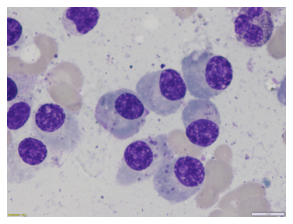

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[15]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

dataset/Labels/2339.bmp


<AxesSubplot:>

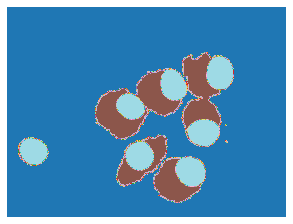

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
np.unique(np.array(mask))

array([ 0, 20, 40], dtype=uint8)

In [19]:
size = (1000,1333)
bs = 2

In [20]:
codes

array(['Background', 'Cytoplasm', 'Nucleus'], dtype='<U10')

In [21]:
def my_get_items(folders,path):
    return (get_image_files(path))

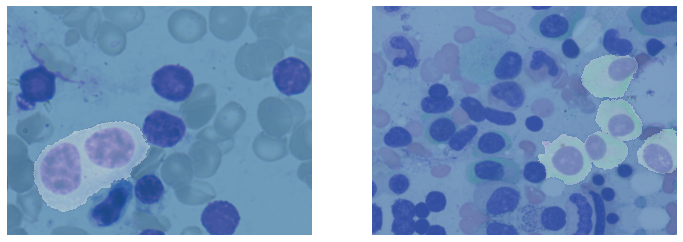

In [22]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize(size), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [23]:
#x,mask=dls.one_batch()

# HRNet

In [24]:
CLASS_WEIGHTS = [0.25,0.75,0.75]
weights = Tensor(CLASS_WEIGHTS).cuda()
loss_func = CrossEntropyLossFlat(axis=1, weight=weights)

In [25]:
learn = get_segmentation_learner(dls=dls, number_classes=3, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[background,cytoplasm,nucleus,msa],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

In [26]:
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,cytoplasm,nucleus,msa,time
0,0.249473,0.729352,0.937711,0.717693,0.717389,0.733012,03:34
1,0.199671,0.354433,0.385659,0.948391,0.941336,0.908412,03:32
2,0.203155,6.613695,0.178420,0.915556,0.907849,0.865045,03:34
3,0.185947,0.330077,0.743925,0.899884,0.908914,0.894406,03:34
4,0.195327,0.192803,0.599861,0.959202,0.945838,0.929641,03:29
5,0.174058,0.182478,0.742163,0.946783,0.939036,0.929388,03:34
6,0.163806,0.328849,0.905657,0.877095,0.874029,0.877757,03:34
7,0.161572,0.171770,0.634266,0.955280,0.947654,0.930559,03:30
8,0.152776,0.157342,0.774376,0.951804,0.948849,0.938929,03:30
9,0.150215,0.178225,0.824281,0.936605,0.928447,0.925844,03:35


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Better model found at epoch 0 with valid_loss value: 0.7293515801429749.


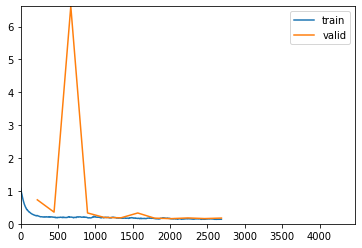

Better model found at epoch 1 with valid_loss value: 0.3544327914714813.
Better model found at epoch 3 with valid_loss value: 0.3300766050815582.
Better model found at epoch 4 with valid_loss value: 0.1928032636642456.
Better model found at epoch 5 with valid_loss value: 0.1824778914451599.
Better model found at epoch 7 with valid_loss value: 0.1717698574066162.
Better model found at epoch 8 with valid_loss value: 0.15734247863292694.
No improvement since epoch 8: early stopping


In [27]:
fname="hrnet-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [28]:
learn.load("hrnet-before-unfreeze")
learn.unfreeze()
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,background,cytoplasm,nucleus,msa,time
0,0.152599,0.142616,0.799192,0.954554,0.951771,0.943408,03:35
1,0.148834,0.142353,0.796696,0.954563,0.951850,0.943269,03:34
2,0.147667,0.142702,0.799370,0.954235,0.951549,0.943168,03:33
3,0.148406,0.142079,0.794784,0.954799,0.952050,0.943330,03:29
4,0.149690,0.142696,0.794494,0.954712,0.951787,0.943134,03:30
5,0.140666,0.142280,0.799618,0.954409,0.951642,0.943307,03:34
6,0.152770,0.142144,0.802584,0.954226,0.951444,0.943349,03:29
7,0.142376,0.142136,0.800058,0.954445,0.951630,0.943346,03:27


Better model found at epoch 0 with valid_loss value: 0.1426161825656891.


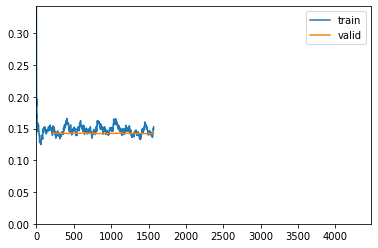

Better model found at epoch 1 with valid_loss value: 0.14235252141952515.
Better model found at epoch 3 with valid_loss value: 0.14207877218723297.
No improvement since epoch 3: early stopping


In [29]:
fname="hrnet-after-unfreeze"


callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [30]:
learn.validate()

(#5) [0.14207877218723297,0.7947841286659241,0.9547990560531616,0.9520504474639893,0.9433304667472839]

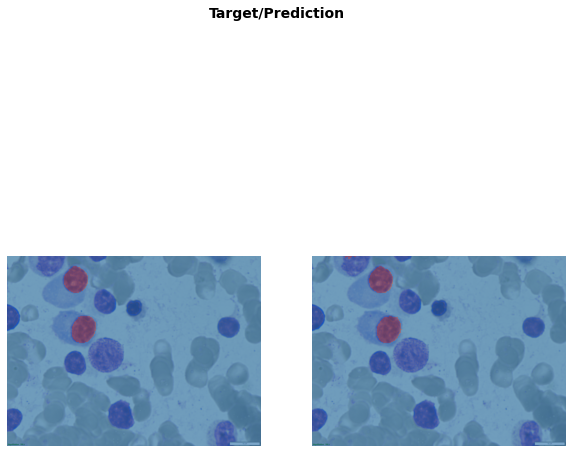

In [31]:
learn.show_results(figsize=(10,10))

In [32]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("hrnet.pth")